In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# from PIL import Image
# import seaborn as sns
# sns.set()

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
# import torchvision
# from torchvision import datasets, models, transforms
# from torch.utils.data import Dataset, DataLoader
# import torch.nn.functional as F

from sklearn.model_selection import train_test_split
# from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.utils.class_weight import compute_class_weight


from glob import glob
from skimage.io import imread
from os import listdir
import seaborn as sns
sns.set()

import time
import copy
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
# from keras.optimizers import Adam
import cv2

### Load Dataset and Preprocess Data

In [3]:
base_path = "D:/university/concordia/Winter 22/Machine Learning/Project/breast cancer/dataset/"
folder = listdir(base_path)
len(folder)

279

In [4]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)
        
total_images

277524

Storing the image_path, patient_id and the target

In [5]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

,patient_id,path,target
0,10253,D:/university/concordia/Winter 22/Machine Lear...,0
1,10253,D:/university/concordia/Winter 22/Machine Lear...,0
2,10253,D:/university/concordia/Winter 22/Machine Lear...,0
3,10253,D:/university/concordia/Winter 22/Machine Lear...,0
4,10253,D:/university/concordia/Winter 22/Machine Lear...,0


In [6]:
print(data['target'].value_counts())

0    198738
1     78786
Name: target, dtype: int64


In [7]:
data.target.unique()

array([0, 1], dtype=object)

In [8]:
data.shape

(277524, 3)

In [9]:
data.head()
data.loc[:, "target"] = data.target.astype(np.str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   path        277524 non-null  object
 2   target      277524 non-null  object
dtypes: object(3)
memory usage: 8.5+ MB


In [10]:
patients = data.patient_id.unique()

Let's take 20% of patients data.

In [28]:
patients = patients[:round(len(patients)*.2)]

In [29]:
len(patients)

56

In [33]:
train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.3,
                                           random_state=0)
test_ids, dev_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=0)

In [34]:
print(len(train_ids)/patients.shape[0]*100, len(dev_ids)/patients.shape[0]*100, len(test_ids)/patients.shape[0]*100)

69.64285714285714 16.071428571428573 14.285714285714285


Now it's 70 % train and 15 % for dev and test.

In [35]:
print(len(train_ids), len(dev_ids), len(test_ids))

39 9 8


In [36]:
train_df = data.loc[data.patient_id.isin(train_ids),:].copy()
test_df = data.loc[data.patient_id.isin(test_ids),:].copy()
valid_df = data.loc[data.patient_id.isin(dev_ids),:].copy()

print(f"train set shape: {train_df.shape}")
print(f"test set shape: {test_df.shape}")
print(f"validation set shape: {valid_df.shape}")

train set shape: (50209, 3)
test set shape: (6633, 3)
validation set shape: (12867, 3)


In [37]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [38]:
NUM_CLASSES = 2
target_size = (224,224)
batch_size = 32

In [39]:
train_batches = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

valid_batches = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

test_batches = test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
)

Found 50209 validated image filenames belonging to 2 classes.
Found 12867 validated image filenames belonging to 2 classes.
Found 6633 validated image filenames belonging to 2 classes.


### Target distributions 
Let's take a look at the target distribution difference of the datasets:

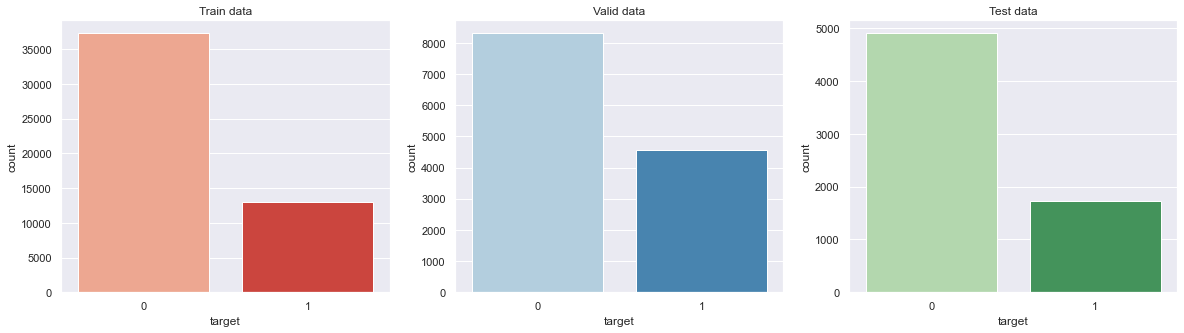

In [40]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(train_df.target, ax=ax[0], palette="Reds")
ax[0].set_title("Train data")
sns.countplot(valid_df.target, ax=ax[1], palette="Blues")
ax[1].set_title("Valid data")
sns.countplot(test_df.target, ax=ax[2], palette="Greens");
ax[2].set_title("Test data");